<a href="https://colab.research.google.com/github/ShawnBrody/Qualifying-Offer-Classifier/blob/master/QO%20Classifier%20for%20Hitters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title In order to start building a model, we must pull in our data from GitHub

! wget https://raw.githubusercontent.com/ShawnBrody/Qualifying-Offer-Classifier/master/Hitters.csv

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, f1_score
import seaborn as sn

Hitters = pd.read_csv("Hitters.csv")

--2019-12-14 05:36:41--  https://raw.githubusercontent.com/ShawnBrody/Qualifying-Offer-Classifier/master/Hitters.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21199 (21K) [text/plain]
Saving to: ‘Hitters.csv’

Hitters.csv         100%[===================>]  20.70K  --.-KB/s    in 0.01s   

2019-12-14 05:36:41 (1.73 MB/s) - ‘Hitters.csv’ saved [21199/21199]



In [0]:
#@title And peek at the hitters data that comes in:
print(Hitters.head())

            Player  Age  Year  playerID  ...   Dol  QOAmount  SalaryOverQO  QO
0  A.J. Pierzynski   35  2012       746  ...  21.3  13300000             0   0
1     Adam LaRoche   32  2012      1904  ...  22.0  13300000             0   1
2    Alex Gonzalez   35  2012       520  ...   1.9  13300000             0   0
3      Angel Pagan   30  2012      2918  ...  29.9  13300000             0   0
4      Carlos Pena   34  2012       934  ...   3.9  13300000             0   0

[5 rows x 26 columns]


With 26 columns in the design matrix, it made sense to do a little downsizing in dimensions. This was done through theoretical dimension reduction (which columns made sense, and for what reason) and which columns were found to be have large feature importances in a full run through a Random Forest. Age, PA, Dol, Salary, G, and fWAR were chosen for theoretical reasons (they put forth necessary information to capture current production and past pay). Off was chosen to represent purely offensive-related production, and was found to have a large feature importance. An explanation of each variable follows:


* Age – Official age of player
* PA – Total Plate Appearances
* Dol – $/fWAR (value created)
* Salary – Actual salary
* Off – Offensive run value
* G – Games appeared in
* fWAR – Wins Above Replacement (FG)


In [0]:
#@title Narrowing down the features to create a design matrix:
# Creates dataframes for design matrix and output variable
Hit_Y = Hitters.iloc[:,-1] # Creates Y variable based on final column
Hit_X = Hitters[['Age', 'PA', 'Dol', 'Salary', 'Off', 'G', 'WAR']] # Uses most important cols to create design matrix

## Optional way to create Hitter design matrix that helps see importance of variables
# Hit_X = Hitters.iloc[:,1:25]
# Hit_X = Hit_X.drop('FRM', axis=1)

# Outputs shape of design matrix
print("Number of rows: {0}".format(Hit_X.shape[0]))
print("Number of columns: {0}".format(Hit_X.shape[1]))

Number of rows: 192
Number of columns: 7


In [0]:
#@title Description of the design matrix:
print(Hit_X.head())

   Age   PA   Dol   Salary   Off    G  WAR
0   35  520  21.3  6000000   9.5  135  3.3
1   32  647  22.0  8000000  19.0  154  3.4
2   35   89   1.9  3500000   0.8   24  0.3
3   30  659  29.9  4850000  21.1  154  4.6
4   34  600   3.9  7250000  -5.1  160  0.6


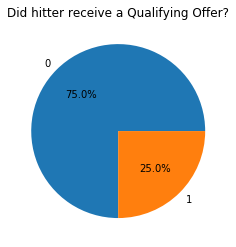

In [0]:
#@title Here we can see the class imbalance at play:
(Hit_Y.value_counts()/Hit_Y.shape[0]).plot(kind='pie', label='', title='Did hitter receive a Qualifying Offer?', autopct='%1.1f%%').get_figure().savefig('hitimb.png')

In [0]:
#@title Describe Class Imbalance and train/test split
### Because we have a smaller dataset and class imbalance, we need to
### up-sample before we train our models

# Doing both of the above, we create our train/test split
Hit_trainX_orig, Hit_testX, Hit_trainY_orig, Hit_testY = train_test_split(Hit_X,
                                         Hit_Y, 
                                         #stratify = Hit_Y,
                                         test_size = 0.2, 
                                         random_state = 42)

print("Full dataset")
print("0:  {0}".format((Hitters.iloc[:,-1]==0).sum()))
print("1:  {0}".format(Hitters.iloc[:,-1].sum()))
print()
print("Validation set")
print("0:  {0}".format((Hit_testY==0).sum()))
print("1:  {0}".format(Hit_testY.sum()))

Full dataset
0:  144
1:  48

Validation set
0:  32
1:  7


Synthetic Minority Over-sampling Technique (SMOTE) can help us take care of our class imbalance problem by over-sampling the minority class. Here we can see the package and function call required to use SMOTE. What will come out is training data that is synthetically balanced:

In [0]:
%%capture
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, ratio=1.0)
Hit_trainX, Hit_trainY = sm.fit_sample(Hit_trainX_orig, Hit_trainY_orig)

In [0]:
#@title SMOTE in practice

# Shows imbalance maintained even with train/test splits, thanks to stratifying
print("Training set before SMOTE")
print("0:  {0}".format((Hit_trainY_orig==0).sum()))
print("1:  {0}".format(Hit_trainY_orig.sum()))
print()
print("Training Set after SMOTE")
print("0:  {0}".format((Hit_trainY==0).sum()))
print("1:  {0}".format(Hit_trainY.sum()))

Training set before SMOTE
0:  112
1:  41

Training Set after SMOTE
0:  112
1:  112


My first attempt at creating a classifier will start with a RandomForest. Using the following parameters, I used sklearn's GridSearchCV function to find optimal hyperparameters:

*   n_estimators (100, 300, 500, 800, 1000)
*   criterion (gini, entropy)
*   max_depth (5, 10, 15)

For a scoring metric I chose f1 score, because of the presence of class imbalance.

In [0]:
%%capture
# Creates and stores Random Forest object
rf = RandomForestClassifier(random_state=0, class_weight=None)

# Sets up a parameter grid to tune hyperparameters
# bootstrap and max_features are left alone, because they never changed
rf_grid_param = {
    'n_estimators': [100, 300, 500, 800, 1000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15],
}

# Puts gridsearch together (takes about 3 minutes to run)
# f1_weighted is better scoring choice because of data imbalance, however SMOTE
# takes care of this imbalance, so we can just use f1 as our scoring metric
rfGridSearch = GridSearchCV(rf, param_grid=rf_grid_param, scoring='f1', cv=3, n_jobs=-1)

# Now we fit the training data to our gridsearch object
rfGridSearch.fit(Hit_trainX, Hit_trainY.ravel())

In [0]:
#@title Next, we seek to choose the best parameters from GridSearchCV
# Now we want to isolate the parameters 
# with the highest f1_weighted score on the train data
print("Best Parameters: {0} \n".format(rfGridSearch.best_params_))


Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100} 



In [0]:
#@title We then fit the validation set to those specifications. Here are the results:
# These now become our estimator parameters
# Now our model is ready to be introduced to our test data
# proba is better than deterministic for roc_auc
rf_best_grid = rfGridSearch.best_estimator_
rf_test_score = f1_score(Hit_testY, rf_best_grid.predict(Hit_testX), average='weighted')
rf_grid_roc_auc = roc_auc_score(Hit_testY, rf_best_grid.predict_proba(Hit_testX)[:,1])

print("Classification Report:\n{0}".format(classification_report(Hit_testY, rf_best_grid.predict(Hit_testX))))
# print("Our best train f1 score is: {0}".format(round(rfGridSearch.best_score_, 4)))
print("Our test f1 score is: {0}".format(round(rf_test_score, 4)))
print("Our test roc_auc score is: {0}".format(round(rf_grid_roc_auc, 4)))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        32
           1       0.70      1.00      0.82         7

    accuracy                           0.92        39
   macro avg       0.85      0.95      0.89        39
weighted avg       0.95      0.92      0.93        39

Our test f1 score is: 0.928
Our test roc_auc score is: 0.9866


In [0]:
#@title Just to get an idea of what columns told us the most, we can also look at Feature Importance
# Creates a pseudo table of feature importances
# (Changing the design matrix at the top will show feature importances for whole dataset)
rf_dict_vals = pd.Series(data=rf_best_grid.feature_importances_,index=Hit_trainX_orig.columns)
print("Feature Importances:\n{0}".format(rf_dict_vals.sort_values(ascending=False)))

Feature Importances:
Salary    0.295934
Dol       0.220246
WAR       0.163585
Off       0.149090
PA        0.088044
G         0.049923
Age       0.033177
dtype: float64


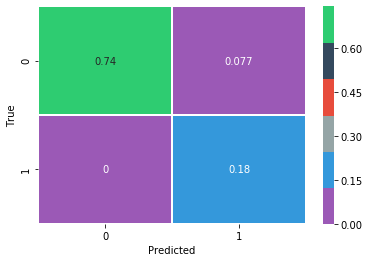

In [0]:
#@title Finally, we look at the confusion matrix to see how our model performed on the validation set
# Class predictions for test data
rf_predictions = rf_best_grid.predict(Hit_testX)

# Confusion matrix for test data
conf_mat_rf = confusion_matrix(Hit_testY, rf_predictions)/Hit_testY.shape[0]

# Plotted Confusion matrix for test data
rf_df_cm = pd.DataFrame(conf_mat_rf, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])
sn.heatmap(rf_df_cm, annot=True, linewidths=0.5, cmap=sn.color_palette(["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"])).set(xlabel="Predicted", ylabel="True")
print()

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       144
           1       0.91      1.00      0.95        48

    accuracy                           0.97       192
   macro avg       0.95      0.98      0.97       192
weighted avg       0.98      0.97      0.97       192

Our overall f1 score is: 0.9744
Our overall roc_auc score is: 0.9968


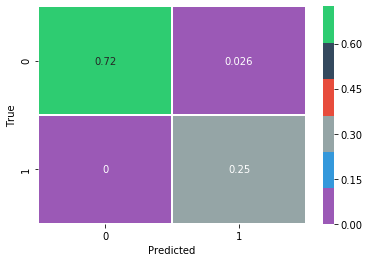

In [0]:
#@title And to get an understanding of how the model performs on the entire dataset:
# Predictions for full dataset
rf_pred_full = rf_best_grid.predict(Hit_X)

# Confusion matrix for full dataset
conf_mat_rf_full = confusion_matrix(Hit_Y, rf_pred_full)/Hit_Y.shape[0]

# Plotted Confusion matrix for full dataset
rf_df_cm_full = pd.DataFrame(conf_mat_rf_full, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])
sn.heatmap(rf_df_cm_full, annot=True, linewidths=0.5, cmap=sn.color_palette(["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"])).set(xlabel="Predicted", ylabel="True")

rf_ovr_f1 = f1_score(Hit_Y, rf_best_grid.predict(Hit_X), average='weighted')
rf_ovr_roc_auc = roc_auc_score(Hit_Y, rf_best_grid.predict_proba(Hit_X)[:,1])

print("Classification Report:\n{0}".format(classification_report(Hit_Y, rf_best_grid.predict(Hit_X))))
print("Our overall f1 score is: {0}".format(round(rf_ovr_f1, 4)))
print("Our overall roc_auc score is: {0}".format(round(rf_ovr_roc_auc, 4)))

In [0]:
#@title An interesting thing we can do here is look at all the players who ended up misclassified. Here are those specific players:
# Who were the ones that fell through the cracks?
da = pd.DataFrame(rf_best_grid.predict(Hit_X)==Hit_Y)
print(Hitters.iloc[da.loc[da['QO']==False].index,0:3])

               Player  Age  Year
43       Hunter Pence   30  2013
67       Adam LaRoche   34  2014
90   Asdrubal Cabrera   29  2015
165    Logan Morrison   29  2017
182  Michael Brantley   31  2018


Interestingly enough, all of these players received contract extensions in the five-day period following the conclusion of the World Series. So these players, who were likely to receive QO's, did not because their eligibility was trumped by a contract extension. This is an area we could adjust in future iterations of our model.

My second attempt at creating a classifier will start with a Logistic Regression. Using the following parameters, I used sklearn's GridSearchCV function to find optimal hyperparameters:

*   C (np.logspace(-4, 4, 20))
*   class_weight (None, balanced)
*   penalty (l1, l2)

For a scoring metric I chose f1 score, because of the presence of class imbalance.

In [0]:
%%capture
from sklearn.linear_model import LogisticRegression

# Creates and stores Random Forest object
logr = LogisticRegression()

# Sets up a parameter grid to tune hyperparameters
# bootstrap and max_features are left alone, because they never changed
logr_grid_param = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'class_weight': [None, 'balanced'] 
}

# Puts gridsearch together
# f1_weighted is better scoring choice because of data imbalance, however SMOTE
# takes care of this imbalance, so we can just use f1 as our scoring metric
logrGridSearch = GridSearchCV(logr, param_grid=logr_grid_param, scoring='f1', cv=3, n_jobs=-1)

# Now we fit the training data to our gridsearch object
logrGridSearch.fit(Hit_trainX, Hit_trainY.ravel())

In [0]:
#@title Next, we seek to choose the best parameters from GridSearchCV
# Now we want to isolate the parameters 
# with the highest f1_weighted score on the train data
print("Best Parameters: {0} \n".format(logrGridSearch.best_params_))

Best Parameters: {'C': 206.913808111479, 'class_weight': 'balanced', 'penalty': 'l1'} 



In [0]:
#@title We then fit the validation set to those specifications. Here are the results:
# These now become our estimator parameters
# Now our model is ready to be introduced to our test data
# proba is better than deterministic for roc_auc
logr_best_grid = logrGridSearch.best_estimator_
logr_test_score = f1_score(Hit_testY, logr_best_grid.predict(Hit_testX), average='weighted')
logr_grid_roc_auc = roc_auc_score(Hit_testY, logr_best_grid.predict_proba(Hit_testX)[:,1])

print("Classification Report:\n{0}".format(classification_report(Hit_testY, logr_best_grid.predict(Hit_testX))))
print("Our test f1 score is: {0}".format(round(logr_test_score, 4)))
print("Our test roc_auc score is: {0}".format(round(logr_grid_roc_auc, 4)))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        32
           1       0.70      1.00      0.82         7

    accuracy                           0.92        39
   macro avg       0.85      0.95      0.89        39
weighted avg       0.95      0.92      0.93        39

Our test f1 score is: 0.928
Our test roc_auc score is: 0.9598


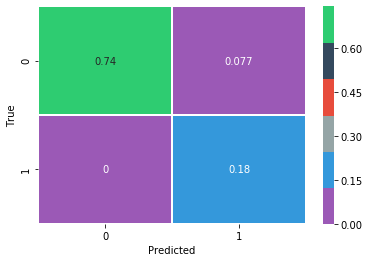

In [0]:
#@title Finally, we look at the confusion matrix to see how our model performed on the validation set
# Class predictions for test data
logr_predictions = logr_best_grid.predict(Hit_testX)

# Confusion matrix for test data
conf_mat_logr = confusion_matrix(Hit_testY, logr_predictions)/Hit_testY.shape[0]

# Plotted Confusion matrix for test data
logr_df_cm = pd.DataFrame(conf_mat_logr, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])
sn.heatmap(logr_df_cm, annot=True, linewidths=0.5, cmap=sn.color_palette(["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"])).set(xlabel="Predicted", ylabel="True")
print()

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       144
           1       0.76      0.85      0.80        48

    accuracy                           0.90       192
   macro avg       0.85      0.88      0.87       192
weighted avg       0.90      0.90      0.90       192

Our overall f1 score is: 0.8978
Our overall roc_auc score is: 0.9459


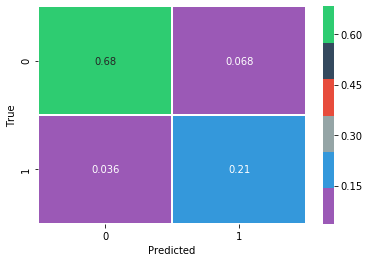

In [0]:
#@title And to get an understanding of how the model performs on the entire dataset:
# Predictions for full dataset
logr_pred_full = logr_best_grid.predict(Hit_X)

# Confusion matrix for full dataset
conf_mat_logr_full = confusion_matrix(Hit_Y, logr_pred_full)/Hit_Y.shape[0]

# Plotted Confusion matrix for full dataset
logr_df_cm_full = pd.DataFrame(conf_mat_logr_full, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])
sn.heatmap(logr_df_cm_full, annot=True, linewidths=0.5, cmap=sn.color_palette(["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"])).set(xlabel="Predicted", ylabel="True")

logr_ovr_f1 = f1_score(Hit_Y, logr_best_grid.predict(Hit_X), average='weighted')
logr_ovr_roc_auc = roc_auc_score(Hit_Y, logr_best_grid.predict_proba(Hit_X)[:,1])

print("Classification Report:\n{0}".format(classification_report(Hit_Y, logr_best_grid.predict(Hit_X))))
print("Our overall f1 score is: {0}".format(round(logr_ovr_f1, 4)))
print("Our overall roc_auc score is: {0}".format(round(logr_ovr_roc_auc, 4)))

My final attempt at creating a classifier will be a Gaussian Naive Bayes. I used sklearn's GridSearchCV function, however one of the benefits of GNB is that it works rather effectively OOTB. Therefore, there are no hyperparameters to tune here.

For a scoring metric I chose f1 score, because of the presence of class imbalance.

In [0]:
%%capture
from sklearn.naive_bayes import GaussianNB

# Creates and stores Random Forest object
gnb = GaussianNB()

# Sets up a parameter grid to tune hyperparameters
# bootstrap and max_features are left alone, because they never changed

gnb_grid_param = {
    
}


# Puts gridsearch together
# f1_weighted is better scoring choice because of data imbalance, however SMOTE
# takes care of this imbalance, so we can just use f1 as our scoring metric
gnbGridSearch = GridSearchCV(gnb, param_grid=gnb_grid_param, scoring='f1', cv=3, n_jobs=-1,)

# Now we fit the training data to our gridsearch object
gnbGridSearch.fit(Hit_trainX, Hit_trainY.ravel())

In [0]:
#@title We then fit the validation set to those specifications. Here are the results:

# Now our model is ready to be introduced to our test data
# proba is better than deterministic for roc_auc
gnb_best_grid = gnbGridSearch.best_estimator_
gnb_test_score = f1_score(Hit_testY, gnb_best_grid.predict(Hit_testX), average='weighted')
gnb_grid_roc_auc = roc_auc_score(Hit_testY, gnb_best_grid.predict_proba(Hit_testX)[:,1])

print("Classification Report:\n{0}".format(classification_report(Hit_testY, gnb_best_grid.predict(Hit_testX))))
print("Our test f1 score is: {0}".format(round(gnb_test_score, 4)))
print("Our test roc_auc score is: {0}".format(round(gnb_grid_roc_auc, 4)))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.75      0.84        32
           1       0.43      0.86      0.57         7

    accuracy                           0.77        39
   macro avg       0.69      0.80      0.71        39
weighted avg       0.86      0.77      0.79        39

Our test f1 score is: 0.7935
Our test roc_auc score is: 0.8884


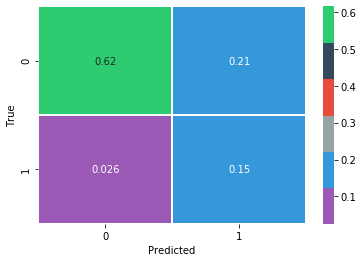

In [0]:
#@title Finally, we look at the confusion matrix to see how our model performed on the validation set
# Class predictions for test data
gnb_predictions = gnb_best_grid.predict(Hit_testX)

# Confusion matrix for test data
conf_mat_gnb = confusion_matrix(Hit_testY, gnb_predictions)/Hit_testY.shape[0]

# Plotted Confusion matrix for test data
gnb_df_cm = pd.DataFrame(conf_mat_gnb, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])
sn.heatmap(gnb_df_cm, annot=True, linewidths=0.5, cmap=sn.color_palette(["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"])).set(xlabel="Predicted", ylabel="True")
print()

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.77      0.86       144
           1       0.57      0.92      0.70        48

    accuracy                           0.81       192
   macro avg       0.77      0.84      0.78       192
weighted avg       0.87      0.81      0.82       192

Our overall f1 score is: 0.8189
Our overall roc_auc score is: 0.885


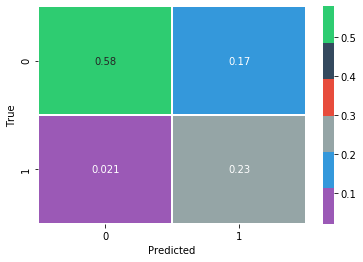

In [0]:
#@title And to get an understanding of how the model performs on the entire dataset:
# Predictions for full dataset
gnb_pred_full = gnb_best_grid.predict(Hit_X)

# Confusion matrix for full dataset
conf_mat_gnb_full = confusion_matrix(Hit_Y, gnb_pred_full)/Hit_Y.shape[0]

# Plotted Confusion matrix for full dataset
gnb_df_cm_full = pd.DataFrame(conf_mat_gnb_full, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])
sn.heatmap(gnb_df_cm_full, annot=True, linewidths=0.5, cmap=sn.color_palette(["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"])).set(xlabel="Predicted", ylabel="True")

gnb_ovr_f1 = f1_score(Hit_Y, gnb_best_grid.predict(Hit_X), average='weighted')
gnb_ovr_roc_auc = roc_auc_score(Hit_Y, gnb_best_grid.predict_proba(Hit_X)[:,1])

print("Classification Report:\n{0}".format(classification_report(Hit_Y, gnb_best_grid.predict(Hit_X))))
print("Our overall f1 score is: {0}".format(round(gnb_ovr_f1, 4)))
print("Our overall roc_auc score is: {0}".format(round(gnb_ovr_roc_auc, 4)))

# Conclusions

Of the three models built, the Random Forest seems to have performed the best. On the validation set, both the Random Forest and Logistic Regression classifier perform similarly and miss the same rows. However, reapplying both on the full set, the Random Forest model comes out with a better `f1` and `ROC_AUC` score. In general, both models perform well and new data would help better understand which model works better.

To solve this issue, I could apply data from the 2019 season to both models and see how the testing metrics change. Overall, I feel confident that both models work in the ways I hoped they would. Both, and the Random Forest in particular, don't have the many misclassifications of players that received a QO when they were predicted not to. This can be particulary useful, as it can help players and agents more accurately predict when they are about to receive a QO offer with enough lead-time to act accordingly.